In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.getcwd()

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
# path = './drive/MyDrive/...'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
# os.chdir(path)

In [5]:
# os.getcwd()

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [6]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [7]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [8]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [9]:
os.listdir('data/')

['submission.csv', 'test.csv', 'train.csv']

In [10]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [11]:
train_y

0     8179.056
1     8135.640
2     8107.128
3     8048.808
4     8043.624
        ...   
83    8386.416
84    8435.664
85    8591.184
86    8638.488
87    8663.112
Name: Wh, Length: 88, dtype: float64

In [12]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temp           88 non-null     float64
 1   Wind           88 non-null     float64
 2   Moisture       88 non-null     float64
 3   Precipitation  88 non-null     float64
 4   Sun            88 non-null     float64
dtypes: float64(5)
memory usage: 3.6 KB


In [13]:
train_y.shape

(88,)

In [14]:
train_x.shape

(88, 5)

In [15]:
mer = pd.merge(train_x,train_y,left_index = True, right_index = True)

In [16]:
mer.corr()

,Temp,Wind,Moisture,Precipitation,Sun,Wh
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
Wh,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


C:\Users\82107\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Wind', ylabel='Density'>

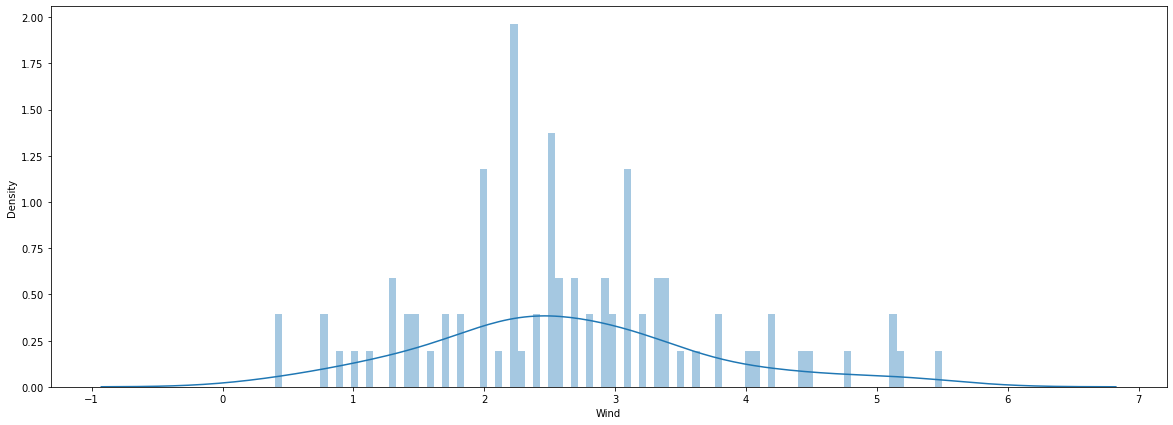

In [17]:
plt.figure(figsize=(20,7))
sns.distplot(train_x['Wind'],bins = 88)

C:\Users\82107\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Temp', ylabel='Density'>

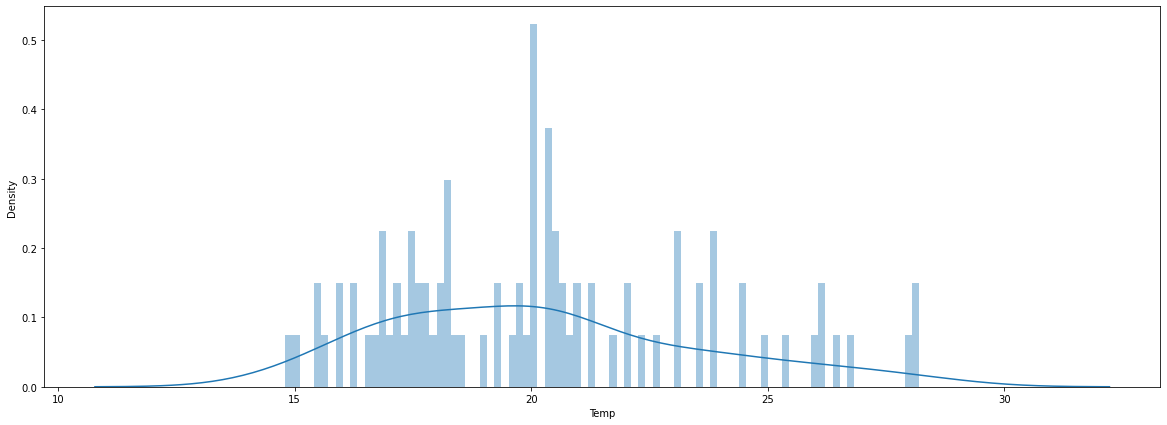

In [18]:
plt.figure(figsize=(20,7))
sns.distplot(train_x['Temp'],bins = 88)

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 전부 쓰겠습니다.  
개수를 제한해서 해야한다면 Temp, Sun, Wind 순 으로 하겠지만 단순히 선형적인 상관관계만 있다고 확신할 수 없기에 다 써보겠습니다!

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [19]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
scaler.fit(train_x)

StandardScaler()

In [21]:
pd.DataFrame(scaler.transform(train_x))

,0,1,2,3,4
0,-0.809423,-0.121390,1.321326,3.465043,-0.704318
1,-0.778800,0.250169,1.258338,1.189493,-0.704318
2,-0.840046,0.528839,1.258338,-0.175838,-0.704318
3,-0.962538,0.528839,1.258338,-0.175838,-0.704318
4,-0.993161,0.621729,1.321326,-0.175838,-0.704318
...,...,...,...,...,...
83,1.119829,0.157280,-0.190397,-0.175838,0.748338
84,1.456682,0.435949,-0.505339,-0.175838,1.232557
85,1.762913,0.435949,-0.694305,-0.175838,1.716775
86,1.885405,1.086179,-0.694305,-0.175838,1.716775


In [22]:
train_x_std = scaler.transform(train_x)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [23]:
# 사용할 패키지를 import!
from sklearn.linear_model import LinearRegression

In [24]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
model = LinearRegression().fit(train_x_std,train_y)

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [25]:
esti_y = model.predict(train_x_std)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [26]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [27]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 2832.76020


In [28]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

In [29]:
# visualization 하실 분은 진행해주세요!
# visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [30]:
#transform을 하시는 분들은 실행해주세요
test_x_std = scaler.transform(test_x)

In [31]:
# y1_hat에 predict값 할당
pred_y = model.predict(test_x_std)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [32]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [33]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 91231.18222


In [34]:
score(train_mse,test_mse)

 32.2058


In [35]:
# visualization 하실 분은 진행해주세요!
# visualize(model, test_x, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

In [36]:
# temp sun wind 로 만 
train_x2 = train_x[['Temp','Wind','Sun']]
test_x2 = test_x[['Temp','Wind','Sun']]

In [37]:
scaler2 = StandardScaler()
train_x2_std = scaler2.fit_transform(train_x2)

model2 = LinearRegression()
model2 = model2.fit(train_x2_std, train_y)

In [49]:
# trainset에 대한 mse
esti_y2 = model2.predict(train_x2_std)
train_mse2 = mse(esti_y2,train_y)
train_mse2

11423.02778668675

In [50]:
pred_y2 = model2.predict(scaler2.transform(test_x2))
test_mse2 = mse(pred_y2, test_y)
test_mse2

141348.44776582933

In [53]:
score(train_mse2,test_mse2)

 12.3740


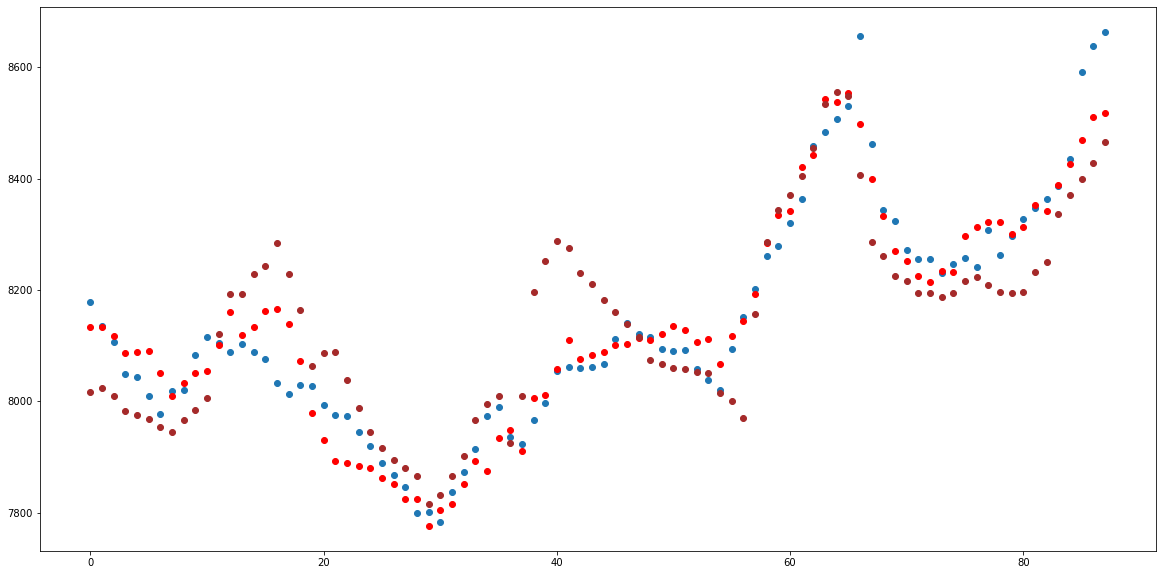

In [55]:
# train set 예측 비교 (개형말고 y값만 비교)--> 변수 선별할수록 under fitting
plt.figure(figsize=(20,10))
plt.scatter(x = range(len(train_y)),y = train_y)
plt.scatter(x = range(len(train_y)),y = esti_y, color ='r')
plt.scatter(x = range(len(train_y)), y = esti_y2, color = 'brown')

Text(0.5, 0, 'Temperature')

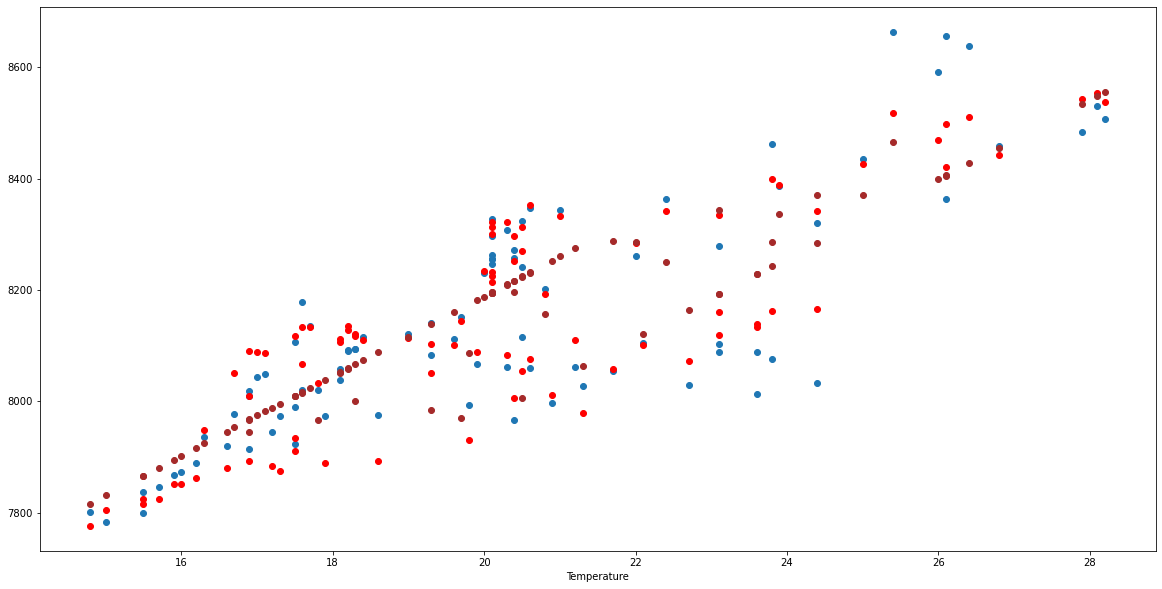

In [56]:
# Temp 에 대한 전력
plt.figure(figsize=(20,10))
plt.scatter(x= train_x['Temp'],y = train_y)
plt.scatter(x= train_x['Temp'],y = esti_y, color ='r')
plt.scatter(x= train_x['Temp'], y = esti_y2, color = 'brown')
plt.xlabel('Temperature')

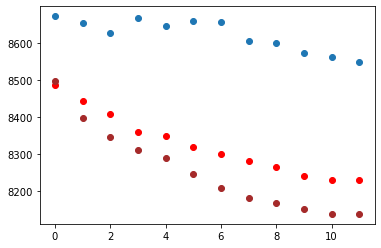

In [42]:
# test set 예측 비교 (y값만 비교)--- > 1차 선형회귀는 변수 전부 포함한게 그나마 잘나옴 --> 하지만 사실상 1차 선형회귀로는 적합한 모델은 아닌듯
plt.scatter(x = range(len(test_y)),y = test_y)
plt.scatter(x = range(len(test_y)),y = pred_y, color ='r')
plt.scatter(x = range(len(test_y)), y = pred_y2, color = 'brown')

### 당연하게도 feature가 적은만큼 1차 선형회귀는 여기서 적합한 모델이 아님
### 때문에 여기서 feature를 더 선별하여 사용하면 error가 더 증가함

### 선형회귀를 쓸거면 1차보다는 다항이 적합해 보임!

고생하셨습니다!